# TP1: Logique floue

DOULFAQAR Abdellah

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Exercice 1

In [2]:
Distance_to_next_car = ctrl.Antecedent(np.arange(0, 30, 1), 'Distance_to_next_car')
Distance_to_next_car['v_small'] = fuzz.trapmf(Distance_to_next_car.universe, [0, 0, 5, 10])
Distance_to_next_car['small'] = fuzz.trimf(Distance_to_next_car.universe, [7, 11, 15])
Distance_to_next_car['perfect'] = fuzz.trimf(Distance_to_next_car.universe, [12, 16, 20])
Distance_to_next_car['big'] = fuzz.trimf(Distance_to_next_car.universe, [17, 22, 25])
Distance_to_next_car['v_big'] = fuzz.trapmf(Distance_to_next_car.universe, [23, 27, 30, 30])

c:\Users\abdel\AppData\Local\Programs\Python\Python312\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


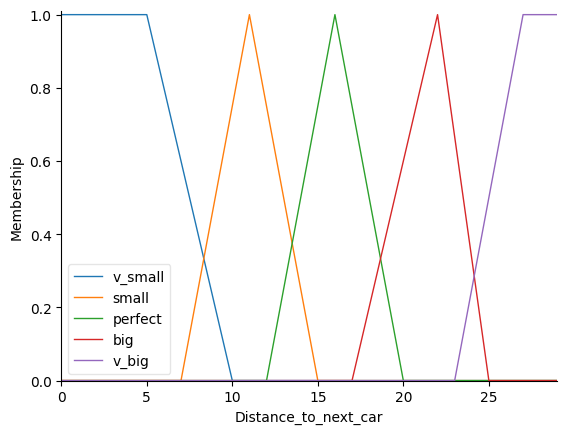

In [3]:
Distance_to_next_car.view()

## Exercice 2

In [4]:
Speed_change = ctrl.Antecedent(np.arange(-20, 25, 1), 'Speed_change')
Speed_change['declining'] = fuzz.trimf(Speed_change.universe, [-20, -15, -10])
Speed_change['constant'] = fuzz.trapmf(Speed_change.universe, [-15, -5, 5, 15])
Speed_change['growing'] = fuzz.trimf(Speed_change.universe, [10, 15, 20])

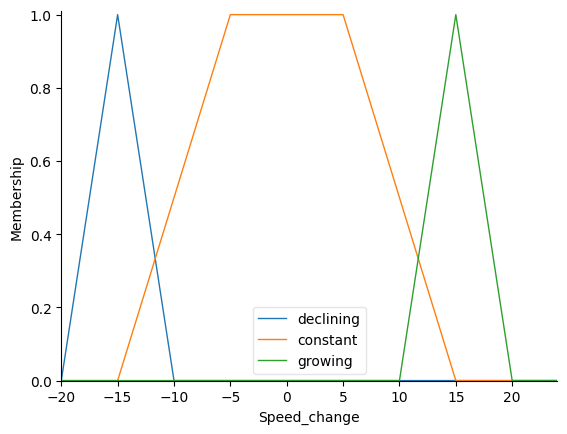

In [5]:
Speed_change.view()

## Exercice 3

In [6]:
Acceleration_Adjust = ctrl.Consequent(np.arange(-3, 4, 1), 'Acceleration_Adjust')
Acceleration_Adjust['neg_big'] = fuzz.trapmf(Acceleration_Adjust.universe, [-3, -3, -2, -1])
Acceleration_Adjust['neg_small'] = fuzz.trimf(Acceleration_Adjust.universe, [-2, -1, 0])
Acceleration_Adjust['zero'] = fuzz.trimf(Acceleration_Adjust.universe, [-1, 0, 1])
Acceleration_Adjust['pos_small'] = fuzz.trimf(Acceleration_Adjust.universe, [0, 1, 2])
Acceleration_Adjust['pos_big'] = fuzz.trapmf(Acceleration_Adjust.universe, [1, 2, 3, 3])

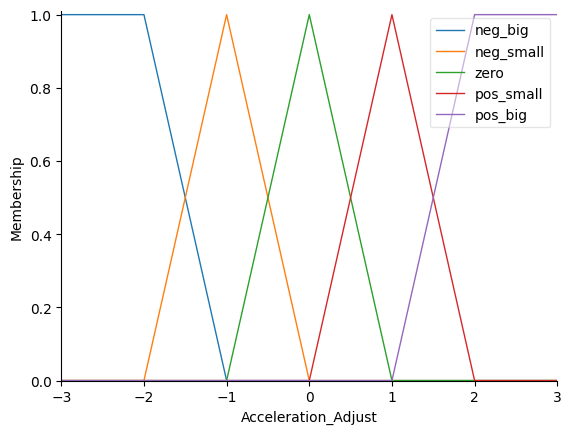

In [7]:
Acceleration_Adjust.view()

## Exercice 4

In [8]:
rule1 = ctrl.Rule(Distance_to_next_car['v_small'] & Speed_change['declining'], Acceleration_Adjust['neg_small'])
rule2 = ctrl.Rule(Distance_to_next_car['v_small'] & Speed_change['constant'], Acceleration_Adjust['neg_big'])
rule3 = ctrl.Rule(Distance_to_next_car['v_small'] & Speed_change['growing'], Acceleration_Adjust['neg_big'])

rule4 = ctrl.Rule(Distance_to_next_car['small'] & Speed_change['declining'], Acceleration_Adjust['zero'])
rule5 = ctrl.Rule(Distance_to_next_car['small'] & Speed_change['constant'], Acceleration_Adjust['neg_small'])
rule6 = ctrl.Rule(Distance_to_next_car['small'] & Speed_change['growing'], Acceleration_Adjust['neg_big'])

rule7 = ctrl.Rule(Distance_to_next_car['perfect'] & Speed_change['declining'], Acceleration_Adjust['pos_small'])
rule8 = ctrl.Rule(Distance_to_next_car['perfect'] & Speed_change['constant'], Acceleration_Adjust['zero'])
rule9 = ctrl.Rule(Distance_to_next_car['perfect'] & Speed_change['growing'], Acceleration_Adjust['neg_small'])

rule10 = ctrl.Rule(Distance_to_next_car['big'] & Speed_change['declining'], Acceleration_Adjust['pos_big'])
rule11 = ctrl.Rule(Distance_to_next_car['big'] & Speed_change['constant'], Acceleration_Adjust['pos_small'])
rule12 = ctrl.Rule(Distance_to_next_car['big'] & Speed_change['growing'], Acceleration_Adjust['zero'])

rule13 = ctrl.Rule(Distance_to_next_car['v_big'] & Speed_change['declining'], Acceleration_Adjust['pos_big'])
rule14 = ctrl.Rule(Distance_to_next_car['v_big'] & Speed_change['constant'], Acceleration_Adjust['pos_big'])
rule15 = ctrl.Rule(Distance_to_next_car['v_big'] & Speed_change['growing'], Acceleration_Adjust['pos_small'])

In [9]:
system_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15])
system_simulation= ctrl.ControlSystemSimulation(system_control)
system_simulation.input['Distance_to_next_car'] = 13
system_simulation.input['Speed_change'] = -2.5
system_simulation.compute()
print(system_simulation.output['Acceleration_Adjust'])

-0.643939393939394


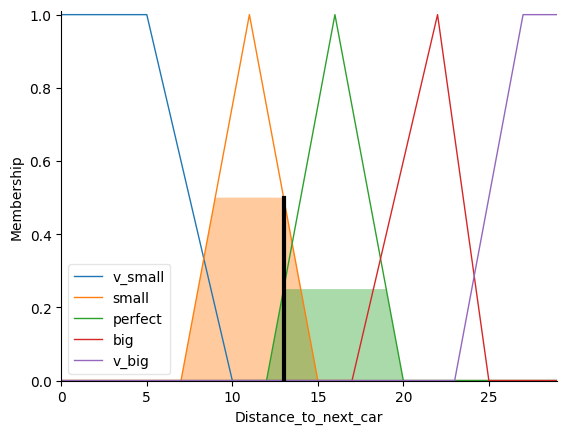

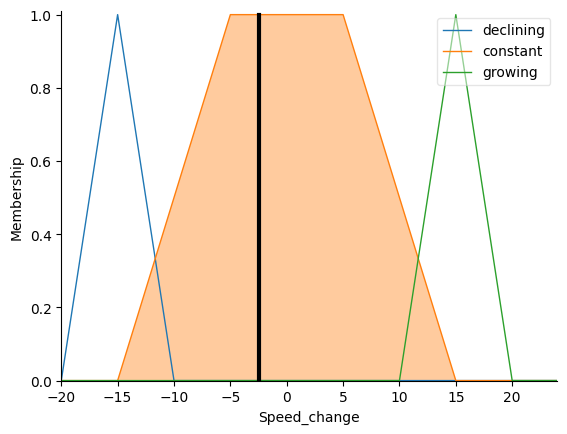

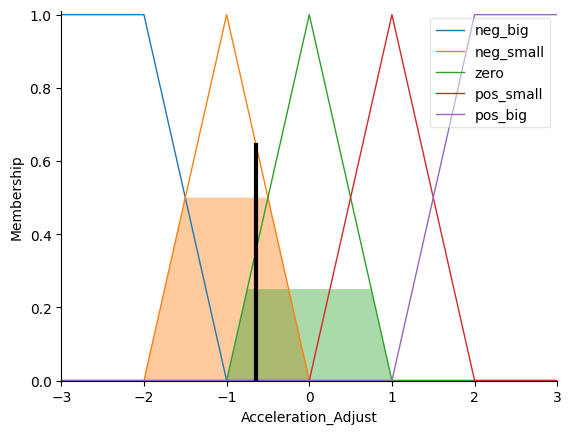

In [10]:
Distance_to_next_car.view(sim=system_simulation)
Speed_change.view(sim=system_simulation)
Acceleration_Adjust.view(sim=system_simulation)


# TP2: Logique floue et intégration du ML

In [11]:
np.random.seed(42)
n_samples = 1000
dist_samples = np.random.uniform(0, 30, n_samples)
speed_samples = np.random.uniform(-20, 20, n_samples)

accel_outputs = []
for d, s in zip(dist_samples, speed_samples):
    system_simulation.input['Distance_to_next_car'] = float(d)
    system_simulation.input['Speed_change'] = float(s)
    system_simulation.compute()
    accel_outputs.append(float(system_simulation.output['Acceleration_Adjust']))

df = pd.DataFrame({
    'Distance_to_next_car': dist_samples,
    'speed_change': speed_samples,
    'acceleration_adjust': accel_outputs
})

print(df.shape)
df.head()

(1000, 3)


,Distance_to_next_car,speed_change,acceleration_adjust
0,11.236204,-12.594683,-0.342297
1,28.521429,1.676038,2.222222
2,21.959818,14.917833,0.014797
3,17.959755,9.288995,0.298125
4,4.680559,12.262446,-2.108313


In [12]:
X = df[['Distance_to_next_car', 'speed_change']].values
y = df['acceleration_adjust'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

MAE: 0.02656908387413372
MSE: 0.0021879179478244875


In [13]:
# create a dataframe that combines the test inputs, LF targets and predicted targets
df_results = pd.DataFrame(X_test, columns=['Distance_to_next_car', 'speed_change'])
df_results['acceleration_LF'] = y_test
df_results['acceleration_pred'] = y_pred
df_results['abs_error'] = np.abs(df_results['acceleration_LF'] - df_results['acceleration_pred'])

print(df_results.shape)
df_results.head()

(200, 5)


,Distance_to_next_car,speed_change,acceleration_LF,acceleration_pred,abs_error
0,11.426726,17.377441,-2.124531,-2.128343,0.003811
1,24.497983,-12.215100,1.780161,1.892660,0.112499
2,13.880394,13.101516,-1.146589,-1.151429,0.004839
3,10.682902,4.023773,-1.000000,-1.000243,0.000243
4,28.501859,-15.523215,2.202321,2.185716,0.016606


### Comparaison entre model et logique floue

In [14]:
example = {'Distance_to_next_car': 9.5, 'speed_change': -3.0}

d = float(example['Distance_to_next_car'])
s = float(example['speed_change'])

In [15]:
system_simulation.input['Distance_to_next_car'] = d
system_simulation.input['Speed_change'] = s
system_simulation.compute()
accel_fuzzy = float(system_simulation.output['Acceleration_Adjust'])

In [ ]:
accel_model = float(model.predict(np.array([[d, s]]))[0])

In [17]:
print(f"Input -> Distance_to_next_car: {d} | speed_change: {s}")
print(f"Logique floue acceleration_adjust: {accel_fuzzy:.6f}")
print(f"Acceleration_adjust (prédiction): {accel_model:.6f}")
print(f"Erreur absolue: {abs(accel_fuzzy - accel_model):.6f}")

Input -> Distance_to_next_car: 9.5 | speed_change: -3.0
Logique floue acceleration_adjust: -1.176393
Acceleration_adjust (prédiction): -1.161315
Erreur absolue: 0.015078


# Conclusion

- Le modèle ML approxime bien mais avec des erreur sur les données simulées.
- Logique floue : explicable, contrôlable via règles, fiable pour systèmes critiques et comportement attendu.